In [1]:
#importing libraries

import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from IPython.core.ultratb import VerboseTB
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
VerboseTB._tb_highlight = "bg:#039dfc"
import scipy.optimize as spo

In [2]:
# class for technical indicators. I receives a dataframe and returns, for each method, 
# a new column with the values calculated based on an input column.

class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    # calculation of the return of column after an interval of n days
    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df.loc[offset:,column]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']
    
    # moving average of column i of returns through n days
    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df.loc[offset:,column].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']
    
    # calculate upper and lower 2*std_deviation lines
    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band
    
    # moving average and +/- 2*std_deviation lines
    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df.loc[offset:,column].rolling(window_size).mean()
            self.df.loc[0:window_size,f'{column}_mm20'] =  self.df.loc[window_size,f'{column}_mm20']
            rstd = self.df.loc[offset:,column].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]
    
    # daily and cumulative returns of column
    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df.loc[0,f'{column}_daily_return'] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df.loc[0,f'{column}_cumulative_return'] = 0
        
    # log return after n days of column
    def log_returns(self,column,n):
        self.df[f'{column}_log_return_{n}'] = np.log((self.df[column] / self.df[column].shift(n)))
        self.df.loc[0:n,f'{column}_log_return_{n}'] = self.df.loc[n,f'{column}_log_return_{n}']
        return self.df[f'{column}_log_return_{n}']
    

In [3]:
# get stock (ticker) data from yahoo finance from start to end dates
class stock_dataframe():
    def __init__(self,ticker,start,end):
        self.ticker = ticker
        self.start = start 
        self.end = end
        
    def get_stock_data(self):
        start_date = date.fromisoformat(self.start)
        end_date = date.fromisoformat(self.end)
        start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
        end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
        print(start_date, end_date)
        #self.start_stamp = datetime.timestamp(self.start_date)
        #self.end_stamp = datetime.timestamp(self.end_date)
        print(start_stamp,end_stamp)
        url = "https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedClose=true" % (self.ticker,start_stamp,end_stamp)
        print(url)
        self.stock = pd.read_csv(url)
        print(self.stock)
        self.stock.rename(columns={"Adj Close":"AC"}, inplace=True)
        return self.stock
    
    # Convert Date to Day, Month and Year columns.
    def Date_Convert(self):
        self.stock['Date'] = pd.to_datetime(self.stock['Date'])
        self.stock['Year'] = self.stock['Date'].dt.year
        self.stock['Month'] = self.stock['Date'].dt.month
        self.stock['Day'] = self.stock['Date'].dt.day
        
    # define Scaler
    def Standard_Scaler(self):
        self.scaler = StandardScaler()
    
    def Min_Max_Scaler(self):
        self.scaler = MinMaxScaler()
        
    # Calculate technical indicators    
    def Get_Technical_Indicators(self,price):
        TI = TechnicalIndicators(self.stock)
        TI.momentum(price,15)
        TI.simple_movement_average(price,15)
        TI.bollinger_bands(price,15)
        TI.add_daily_return(price)
        TI.log_returns(price,1)
        self.stock = TI.df
        return self.stock
        
    # Perform Chosen normalization    
    def Normalize(self):
        # Define the column to leave unchanged
        unchanged_column = 'Date'

        # Create a subset of columns excluding the unchanged column
        columns_to_scale = [col for col in self.stock.columns if col != unchanged_column]

        # Copy the DataFrame
        stock_normalized = self.stock.copy()

        # Apply StandardScaler to the subset of columns
        stock_normalized[columns_to_scale] = self.scaler.fit_transform(self.stock[columns_to_scale])

        print(stock_normalized)

        # Concatenate the normalized subset with the unchanged column
        stock_normalized = pd.concat([stock_normalized[unchanged_column], stock_normalized[columns_to_scale]], axis=1)

        # rename adjusted close to avoid spaces 

        return stock_normalized



In [4]:
# Merge stock dataframes for all options in a single dataframe 
def merge_stocks(options):
    df = pd.DataFrame()
    for stock in options:
        print("stock =",stock)
        # define stock data class
        stock_data = stock_dataframe(stock,"2010-01-01","2021-12-31")
        
        # read data
        stock_data.get_stock_data()
        
        # convert Date to Day, Month and Year columns
        stock_data.Date_Convert()
        
        # Calculate additional variables
        stock_data.Get_Technical_Indicators("AC")
        
        # Define scaler 
        stock_data.Standard_Scaler()
        
        print("stock_data.stock = ",stock_data.stock)
        # Apply normalization
        df_stock = stock_data.Normalize()
        
        date_columns = ["Date","Year","Month","Day"]
        # Identify columns with identical values across all DataFrames
        identical_columns = []
        distinct_columns = []

        # merge with other options 
        for col in df_stock.columns:
            if (col in df and col in df_stock):
                if df[col].equals(df_stock[col]): identical_columns.append(col)
            else: 
                if col not in date_columns: df_stock.rename(columns={col: stock + '_' + col}, inplace=True)
        # Identify columns with distinct values across the DataFrames
        distinct_columns = [col for col in df_stock.columns if col not in identical_columns]

        df = pd.concat([df,df_stock[distinct_columns]],axis=1)
    print(df)
    return df

In [5]:
# Class for calculating option weights for an optimal portfolio for each day 
class PortfolioOptimization:
    def __init__(self, data_frame, options):
        self.df = data_frame.copy()
        self.options = options.copy()
        self.init_weights()

     # initialize weights        
    def init_weights(self):
        for stock in self.options:
            if f'{stock}_weight' not in self.df.columns:
                self.df[f"{stock}_weight"] = 1 / len(self.options)

    # constraints for optimization. Might not be needed in case W_i/sum(W_i) is used             
    def _constraints(self, weights):
        return np.sum(weights) - 1
    
    # Sharpe ration calculation of the full portfolio. Currently using constant as risk free return
    def sharpe_ratio(self, weights, returns, std, rfree):
        norm_weights = weights / np.sum(weights)
        total_return = np.sum(norm_weights * returns)
        portfolio_stddev = np.sum(norm_weights*norm_weights*std*std)
        return (total_return - rfree) / portfolio_stddev
    
    # Minimize target funcion, maximizing the Sharpe ratio
    def target_function(self, weights, returns, stddev, rfree):
        return -self.sharpe_ratio(weights, returns, stddev, rfree)

    # weight optimization using scikit.optmize.minimize. Might not be the best choice, still can test alternatives. Need to check optimized values 
    def optimize_weights(self, weights, returns, stddev, rfree):
        constraints = {'type': 'eq', 'fun': self._constraints}
        bounds = [(0, 1) for _ in range(len(weights))]

        result = spo.minimize(
            self.target_function,
            weights,
            args=(returns, stddev, rfree),
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'  # Sequential Least Squares Programming optimizer
        )

        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")

        return result.x
    
    # Apply optimization for each row. 
    def get_optimal_weights(self, rfree):
        weight_columns = [col for col in self.df.columns if col.endswith('_weight')]
        return_columns = [col.replace('_weight', '_AC_log_return_1') for col in weight_columns]
        stddev_columns = [self.df[col].std() for col in return_columns]

        def apply_optimization(row):
            weights = row[weight_columns].values
            returns = row[return_columns].values
            optimal_weights = self.optimize_weights(weights, returns, stddev_columns, rfree)
            return pd.Series(optimal_weights, index=weight_columns)

        # df.apply was tricky to use with a function with many parameters, to be applied in many columns. This was the workaround which worked  
        self.df[weight_columns] = self.df.apply(apply_optimization, axis=1)
        return self.df[weight_columns]

In [6]:
# class for calculating evaluation metrics of the model
class Metrics():
    def __init__(self, in_df, pred_df, targets):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.targets = targets.copy()
        self.out = pd.DataFrame()
        self.mse = {}

    # pull = (predicted - data)/std_dev    
    def pull(self):
        for column in self.targets:
            # Ensure both return Series
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull
        return self.out.filter(like='Pull')

    # chisq = (predicted - data)**2/std_dec**2
    def chisq(self):
        for column in self.targets:
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
        return self.out.filter(like='ChiSq')
    
    # mse = sum(chisq)/n_rows for every row
    def get_mse(self):
        for column in self.targets:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])
        return self.mse

In [7]:
# MLP regressor model
class model():
    def __init__(self, 
             df, 
             features, 
             targets, 
             train_fraction=0.5, 
             validation_fraction=0.25, 
             rwin=90, 
             offset=1, 
             hidden_layers=[20,20,20], 
             learning_rate=0.0001, 
             tolerance = 0.0001):
        self.df = df.copy()
        self.features = features.copy()
        self.targets = targets.copy()
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.rwin = rwin
        self.offset = offset
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.tolerance = tolerance
    
    # copy all parameters, used to update model during validation
    def set_pars(self,rwin,learning_rate,tolerance,hidden_layers):
        self.rwin = rwin
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.tolerance = tolerance

    # split data in training, validation and test sets
    def split_data(self):
        Train_End = round(self.train_fraction*len(self.df))
        Validation_End = round(self.train_fraction*len(self.df)) + round(self.validation_fraction*len(self.df))
        self.Train_Data = self.df[:Train_End]
        self.Validation_Data = self.df[Train_End:Validation_End]
        self.Test_Data = self.df[Validation_End:]
        return self.Train_Data, self.Test_Data

    # initialize and fill arrays for samples and results                                                                     
    def create_samples(self): 
        self.Train_Sample_Array = []
        self.Train_Result_Array = []
        self.Validation_Sample_Array = []
        self.Validation_Result_Array = []
        self.Test_Sample_Array = []
        self.Test_Result_Array = []

        for i in range(0,len(self.Train_Data)-self.rwin - self.offset):
            self.Train_Sample = self.Train_Data[self.features].iloc[i:i+self.rwin]
            self.Train_Sample_row = self.Train_Sample.values.flatten()
            self.Train_Sample_Array.append(self.Train_Sample_row)
            self.Train_Result = self.Train_Data[self.targets].iloc[i+self.rwin + self.offset]
            self.Train_Result_Array.append(self.Train_Result.values)
            #print("Train sample index = ", range(i,i+self.rwin))
            #print("Train_Result index = ", i+self.rwin + self.offset)

        for i in range(0,len(self.Validation_Data)-self.rwin - self.offset):
            self.Validation_Sample = self.Validation_Data[self.features].iloc[i:i+self.rwin]
            self.Validation_Sample_row = self.Validation_Sample.values.flatten()
            self.Validation_Sample_Array.append(self.Validation_Sample_row)
            self.Validation_Result = self.Validation_Data[self.targets].iloc[i+self.rwin + self.offset]
            self.Validation_Result_Array.append(self.Validation_Result.values)
            #print("Validation sample index = ", range(i,i+self.rwin))
            #print("Validation_Result index = ", i+self.rwin + self.offset)
                                                                         
        for i in range(0,len(self.Test_Data)-self.rwin - self.offset):
            self.Test_Sample = self.Test_Data[self.features].iloc[i:i+self.rwin]
            self.Test_Sample_row = self.Test_Sample.values.flatten()
            self.Test_Sample_Array.append(self.Test_Sample_row)
            self.Test_Result = self.Test_Data[targets].iloc[i+self.rwin + self.offset]
            self.Test_Result_Array.append(self.Test_Result.values)
            #print("Test sample index = ", range(i,i+self.rwin))
            #print("Test_Result index = ", i+self.rwin + self.offset)

        #print("Train_Sample_Array:",self.Train_Sample_Array)
        #print("Test_Sample_Array:",self.Test_Sample_Array)

        return self.Train_Sample_Array, self.Test_Sample_Array, self.Train_Result_Array, self.Test_Result_Array

    # make prediction for sample from index_start to index_end                                                                     
    def predict(self, sample, index_start, index_end):    
        Result = pd.DataFrame(self.regr_fit.predict(sample),columns=[self.targets])
        New_index_values = range(index_start,index_end)
        Result.index = New_index_values
        return Result
                                                                         
    # train model and make prediction
    def train_model(self):
        regr = MLPRegressor(random_state=1, 
                                 max_iter=1000, 
                                 hidden_layer_sizes=tuple(self.hidden_layers),
                                 learning_rate_init = self.learning_rate, 
                                 tol = self.tolerance)
        self.regr_fit = regr.fit(self.Train_Sample_Array, 
                                 self.Train_Result_Array)
        Train_start = self.rwin + self.offset
        Train_end = len(self.Train_Data)
        Validation_start = len(self.Train_Data) + self.rwin + self.offset
        Validation_end = len(self.Train_Data) + len(self.Validation_Data)
        Test_start = len(self.Train_Data) + len(self.Validation_Data) + self.rwin + self.offset
        Test_end = len(self.Train_Data) + len(self.Validation_Data) + len(self.Test_Data)
        
        self.Train_Pred = self.predict(self.Train_Sample_Array, 
                                       Train_start,  
                                       Train_end)
        
        self.Validation_Pred = self.predict(self.Validation_Sample_Array, 
                                            Validation_start,  
                                            Validation_end)
        
        self.Test_Pred = self.predict(self.Test_Sample_Array, 
                                      Test_start, 
                                      Test_end)
        return self.regr_fit

    # plot data and prediction for all sets                                                                     
    def plot(self):
        for target in self.targets:
            fig, ax = plt.subplots(figsize=(12, 6))
            self.Train_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Validation_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Test_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Train_Pred[target].plot(ax=ax, label='P'           + target)
            self.Validation_Pred[target].plot(ax=ax, label='P'           + target)
            self.Test_Pred[target].plot(ax=ax, label='P'           + target)
            ax.legend(loc='center left', bbox_to_anchor=(1, 1),fontsize='small')
            #ax.get_legend().get_frame().set_boxstyle("Round,pad=0.5")
            ax.get_legend().get_frame().set_width(5)
            

    # calculate model metrics                                                                    
    def calculate_metrics(self):
        M_Train = Metrics(self.Train_Data[self.targets],self.Train_Pred[self.targets],self.targets)
        self.train_pull  = M_Train.pull()
        self.train_chisq = M_Train.chisq()
        self.train_mse   = M_Train.get_mse()

        M_Validation = Metrics(self.Validation_Data[self.targets],self.Validation_Pred[self.targets],self.targets)
        self.validation_pull  = M_Validation.pull()
        self.validation_chisq = M_Validation.chisq()
        self.validation_mse   = M_Validation.get_mse()

        M_Test = Metrics(self.Test_Data[self.targets],self.Test_Pred[self.targets],self.targets)
        self.test_pull  = M_Test.pull()
        self.test_chisq = M_Test.chisq()
        self.test_mse   = M_Test.get_mse()

        return self

In [41]:
# model optimization
class optimze_model():
    def __init__(self, model, features, targets):
        self.model = model
        self.features = features
        self.targets = targets
    
    # recalculate model metrics
    def get_metrics(self,rwin,learning_rate,tolerance,hidden_layers):
        self.model.set_pars(rwin,learning_rate,tolerance,hidden_layers)
        self.model.split_data()
        self.model.create_samples()
        self.model.train_model()
        self.model.calculate_metrics()
        return self.model
    
    # recalculate mse with new set of pars
    def get_model_mse(self,pars):
        rwin = int(pars[0])
        learning_rate = pars[1]
        tolerance = pars[2]
        hidden_layers = [int(x) for x in pars[3:]]
        self.get_metrics(rwin,learning_rate,tolerance,hidden_layers)
        return sum(self.model.validation_mse.values())/len(self.model.validation_mse)
        
    # initialize parameter array    
    def set_pars(self,
                 rwin,
                 rwin_bounds,
                 learning_rate,
                 learning_rate_bounds,
                 tolerance,
                 tolerance_bounds,
                 hidden_layers,
                 hidden_layers_bounds, 
                 isInt):
        self.pars = [rwin, learning_rate, tolerance] + hidden_layers
        self.bounds = [rwin_bounds, learning_rate_bounds, tolerance_bounds] + hidden_layers_bounds
        self.isInt = isInt 
    
    # callback function for tracking progress
    def callbackF(self,pars, convergence = 0, context = 0):
        print("current pars:", pars)
        print("current convergence:", convergence)
        print("current context:", context)
        print("current sme = ", self.model.test_mse.values())
    
    # optimization using minimize. Does not work because we have integer parameters.
    def minimize(self):
        print("Initial set of parameters:", self.pars)
        result = spo.minimize(self.get_model_mse, 
                              self.pars,
                              callback=self.callbackF,
                              bounds=self.bounds
                              )
        optimal_pars = result.x
        return optimal_pars
    
    # Optimization using differential evolution. Should be able to handle integer parameters    
    def differential_evolution(self, isInt):
        print("Initial set of parameters:", self.pars)
        result = spo.differential_evolution(self.get_model_mse, 
                              self.bounds,
                              maxiter = 10000,
                              callback=self.callbackF,
                              popsize = len(self.pars)*10*2/5,
                              init = 'sobol',
                              recombination = 0.5,
                              tol = 0.001,
                              #workers = -1
                              integrality = self.isInt,
                              disp=True
                              )
        optimal_pars = result.x
        return optimal_pars
        
    def dual_annealing(self):
        print("Initial set of parameters:", self.pars)
        result = spo.dual_annealing(self.get_model_mse, 
                              callback=self.callbackF,
                              bounds=self.bounds
                              )
        optimal_pars = result.x
        return optimal_pars

In [42]:
options = ["ITUB4.SA",
           "VALE3.SA"
          ] 
prices = ["VALE3.SA_AC_log_return_1","ITUB4.SA_AC_log_return_1"]
features = ["VALE3.SA_AC_log_return_1","ITUB4.SA_AC_log_return_1"]
targets = ["VALE3.SA_AC_log_return_1","ITUB4.SA_AC_log_return_1"]


In [43]:
df = merge_stocks(options)
df.index.start

print("df = ",df)

port = PortfolioOptimization(df,options)
port.init_weights()
weights = port.get_optimal_weights(0.00)
print("weights = ", weights)
print("port.df = ",port.df)

df = port.df

stock = ITUB4.SA
2010-01-01 2021-12-31
1262304000 1640908800
https://query1.finance.yahoo.com/v7/finance/download/ITUB4.SA?period1=1262304000&period2=1640908800&interval=1d&events=history&includeAdjustedClose=true
            Date       Open       High        Low      Close  Adj Close  \
0     2010-01-04  17.708261  18.436810  17.708261  18.268333  10.141706   
1     2010-01-05  18.313868  18.386723  18.168158  18.386723  10.207434   
2     2010-01-06  18.327526  18.436810  18.077089  18.227352  10.118952   
3     2010-01-07  18.099855  18.236460  18.008787  18.040663  10.015318   
4     2010-01-08  18.113516  18.113516  17.721922  17.767456   9.863636   
...          ...        ...        ...        ...        ...        ...   
2970  2021-12-23  21.330000  21.570000  21.170000  21.340000  18.776705   
2971  2021-12-27  21.480000  21.700001  21.309999  21.559999  18.970280   
2972  2021-12-28  21.629999  21.700001  21.400000  21.480000  18.899893   
2973  2021-12-29  21.530001  21.5800

weights =        ITUB4.SA_weight  VALE3.SA_weight
0        4.881135e-01         0.511887
1        4.881135e-01         0.511887
2        1.205564e-01         0.879444
3        0.000000e+00         1.000000
4        2.220446e-16         1.000000
...               ...              ...
2970     1.000000e+00         0.000000
2971     7.741033e-01         0.225897
2972     1.000000e+00         0.000000
2973     0.000000e+00         1.000000
2974     0.000000e+00         1.000000

[2975 rows x 2 columns]
port.df =             Date  ITUB4.SA_Open  ITUB4.SA_High  ITUB4.SA_Low  ITUB4.SA_Close  \
0    2010-01-04      -0.649247      -0.579852     -0.614727       -0.569811   
1    2010-01-05      -0.563651      -0.586855     -0.548941       -0.553056   
2    2010-01-06      -0.561721      -0.579852     -0.561968       -0.575610   
3    2010-01-07      -0.593899      -0.607864     -0.571738       -0.602031   
4    2010-01-08      -0.591969      -0.625053     -0.612772       -0.640695   
...        

test pull sum = VALE3.SA_AC_log_return_1_Pull   -121.453690
ITUB4.SA_AC_log_return_1_Pull    -58.110676
dtype: float64
test chisq sum = VALE3.SA_AC_log_return_1_ChiSq    798.734823
ITUB4.SA_AC_log_return_1_ChiSq    622.014815
dtype: float64
test mse sum = 1.0912055592069527


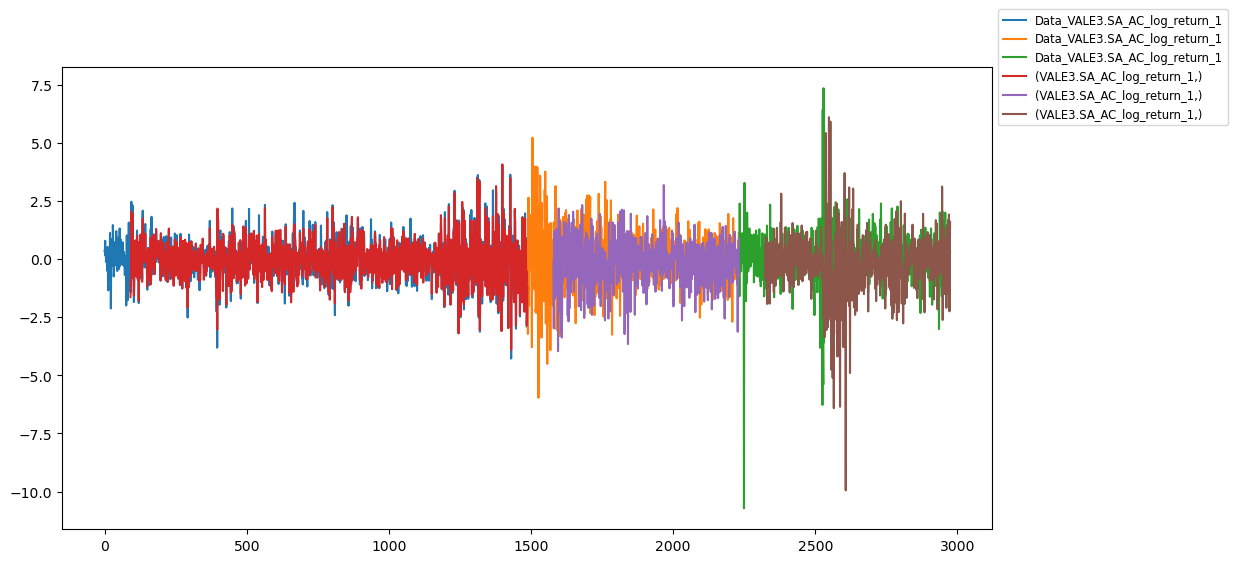

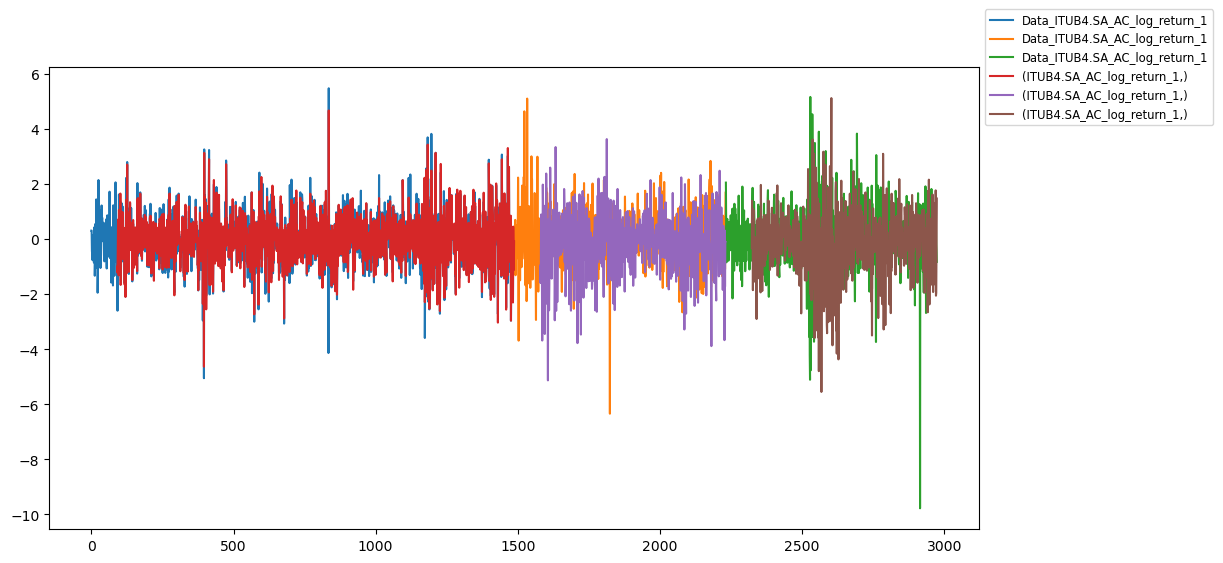

In [44]:
m = model(df,features,targets)
m.split_data()
m.create_samples()
m.train_model()
m.plot()
m.calculate_metrics()
print("test pull sum =", m.test_pull.sum())
print("test chisq sum =", m.test_chisq.sum())
print("test mse sum =", sum(m.test_mse.values())/len(m.test_mse))


In [45]:
opt_model = optimze_model(m,features,targets)

rwin = 90
rwin_bounds = (90,91)
learning_rate = 0.0001
learning_rate_bounds = (0.000000001,0.01)
tolerance_rate = 0.0001
tolerance_rate_bounds = (0.000000001,0.01)
hidden_layers = [20,20]
#hidden_layers_bounds = [(1,100),(1,100),(1,100),(1,100),(1,100)]
hidden_layers_bounds = [(20,20),(20,20)]
isInt = [True,False,False,True,True]


opt_model.set_pars(rwin, 
                   rwin_bounds, 
                   learning_rate, 
                   learning_rate_bounds, 
                   tolerance_rate, 
                   tolerance_rate_bounds, 
                   hidden_layers, 
                   hidden_layers_bounds,isInt)

In [ ]:
optimal_pars = opt_model.differential_evolution(isInt)
print (optimal_pars)

Initial set of parameters: [90, 0.0001, 0.0001, 20, 20]
differential_evolution step 1: f(x)= 0.5921314929097068
current pars: [9.10000000e+01 6.14375153e-04 9.57450975e-03 2.00000000e+01
 2.00000000e+01]
current convergence: 0.0047191300012925635
current context: 0
current sme =  dict_values([1.4353871642627252, 1.2177122477325992])
differential_evolution step 2: f(x)= 0.5921314929097068
current pars: [9.10000000e+01 6.14375153e-04 9.57450975e-03 2.00000000e+01
 2.00000000e+01]
current convergence: 0.00462930698048037
current context: 0
current sme =  dict_values([1.1350189873124445, 1.0239698030697189])
differential_evolution step 3: f(x)= 0.5920991018331991
current pars: [9.10000000e+01 5.75806216e-04 7.90290580e-03 2.00000000e+01
 2.00000000e+01]
current convergence: 0.004438782432017815
current context: 0
current sme =  dict_values([0.9477124710889603, 0.8452170814799727])
differential_evolution step 4: f(x)= 0.5920991018331991
current pars: [9.10000000e+01 5.75806216e-04 7.9029058

/opt/miniconda3/envs/trading/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


differential_evolution step 9: f(x)= 0.5914750503263391
current pars: [9.10000000e+01 6.77397915e-04 9.53521499e-03 2.00000000e+01
 2.00000000e+01]
current convergence: 0.012377264626730482
current context: 0
current sme =  dict_values([0.6615929327926353, 0.543834950947221])
differential_evolution step 10: f(x)= 0.5914750503263391
current pars: [9.10000000e+01 6.77397915e-04 9.59348461e-03 2.00000000e+01
 2.00000000e+01]
current convergence: 0.026801603430078577
current context: 0
current sme =  dict_values([0.7780482529203095, 0.7481815225572168])
differential_evolution step 11: f(x)= 0.5914387839782281
current pars: [9.10000000e+01 6.36776792e-04 9.75208809e-03 2.00000000e+01
 2.00000000e+01]
current convergence: 0.02793077236446324
current context: 0
current sme =  dict_values([0.6015838272591069, 0.5763896360144466])
differential_evolution step 12: f(x)= 0.5914387839782281
current pars: [9.10000000e+01 6.36776792e-04 9.75208809e-03 2.00000000e+01
 2.00000000e+01]
current convergen

In [38]:
optimal_pars = opt_model.dual_annealing()
print (optimal_pars)


Initial set of parameters: [90, 0.0001, 0.0001, 20, 20]
current pars: [9.01190712e+01 9.19741369e-04 3.22488253e-03 2.02837697e+01
 2.09214306e+01]
current convergence: 0.8288140626985849
current context: 0
current sme =  dict_values([0.8321893374054089, 0.7142261895656244])
current pars: [9.06585083e+01 2.56814327e-04 9.78486943e-03 2.07971920e+01
 2.06026057e+01]
current convergence: 0.6985199596983932
current context: 0
current sme =  dict_values([0.7198311292283044, 0.5555005501046756])
current pars: [9.06585083e+01 2.56814327e-04 8.34468965e-03 2.07971920e+01
 2.06026057e+01]
current convergence: 0.6906673576532258
current context: 0
current sme =  dict_values([0.7098752134610088, 0.5534523282508319])
current pars: [9.08186170e+01 1.45485921e-03 9.98961958e-03 2.03010622e+01
 2.03406737e+01]
current convergence: 0.6723578399808171
current context: 0
current sme =  dict_values([0.6898900297157345, 0.5913126808282565])
current pars: [9.08186170e+01 8.23312672e-04 9.98961958e-03 2.03

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
common_indices = Normalized_Train_Data['Vale'].index.intersection(Train_Res['Vale'].index)
common_indices = common_indices[:-1]
Train_Diff = Normalized_Train_Data['Vale'].loc[common_indices] - Train_Res['Vale'].loc[common_indices] 
common_indices = Normalized_Test_Data['Vale'].index.intersection(Res['Vale'].index)
common_indices = common_indices[:-1]
Test_Diff = Normalized_Test_Data['Vale'].loc[common_indices] - Res["Vale"].loc[common_indices]
Train_Diff.plot(ax=ax, label='train')
Test_Diff.plot(ax=ax, label='test')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
common_indices = Normalized_Train_Data['Vale'].index.intersection(Train_Res['Vale'].index)
common_indices = common_indices[:-1]
Train_data_stddev = Normalized_Train_Data['Vale'].loc[common_indices].std()
Train_pred_stddev = Train_Res['Vale'].loc[common_indices].std()
print(Train_data_stddev)
Train_Pull = Train_Diff/math.sqrt(pow(Train_data_stddev,2) + pow(Train_pred_stddev,2))
Train_Pull.plot(ax=ax, label='train')

common_indices = Normalized_Test_Data['Vale'].index.intersection(Res['Vale'].index)
common_indices = common_indices[:-1]
Test_data_stddev = Normalized_Test_Data['Vale'].loc[common_indices].std()
Test_pred_stddev = Res['Vale'].loc[common_indices].std()
print(Test_data_stddev)
Test_Pull = Test_Diff/math.sqrt(pow(Test_data_stddev,2) + pow(Test_pred_stddev,2))
Test_Pull.plot(ax=ax, label='train')

In [ ]:
class Metrics():
    def __init__(self, in_df, pred_df):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.out = pd.DataFrame()
        self.mse = {}

    def pull(self):
        for column in self.pred_df.columns:
            diff = self.pred_df[column] - self.in_df[column] 
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull

    def chisq(self):
        for column in self.pred_df.columns:
            diff = self.pred_df[column] - self.in_df[column] 
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
    
    def get_mse(self):
        for column in self.pred_df.columns:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])

In [ ]:
M_Train = Metrics(Normalized_Train_Data,Train_Res)
print(M_Train.pull())
print(M_Train.chisq())

print(M_Train.get_mse())
print(M_Train.out)
print(M_Train.mse)
M_Test = Metrics(Normalized_Test_Data,Res)
print(M_Test.pull())
print(M_Test.chisq())

print(M_Test.get_mse())
print(M_Test.out)
print(M_Test.mse)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
Normalized_Train_Data['Itau'].plot(ax=ax, label='train')
Normalized_Test_Data['Itau'].plot(ax=ax, label='test')
Res['Itau'].plot(ax=ax,label="Prediction")
Train_Res['Itau'].plot(ax=ax,label="Train_Prediction")
ax.legend();

In [ ]:
Normalized_Train_Data.columns[0]


In [ ]:
class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df[column].iloc[offset:]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']

    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df[column].iloc[offset:].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']

    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band

    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df[column].iloc[offset:].rolling(window_size).mean()
            self.df[f'{column}_mm20'].iloc[0:window_size] =  self.df[f'{column}_mm20'].iloc[window_size]
            rstd = self.df[column].iloc[offset:].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]

    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df[f'{column}_daily_return'].iloc[0] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df[f'{column}_cumulative_return'].iloc[0] = 0

In [ ]:
TF = TechnicalIndicators(Normalized_Train_Data)
print(TF.df)
print(type(TF.df))
for column in Normalized_Train_Data:
    print(TF.momentum(column,15))
    print(TF.simple_movement_average(column,15))
    print(TF.bollinger_bands(column,15))
    print(TF.add_daily_return(column))
print(TF.df)

In [ ]:
import torch
from torch import nn
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
print(h0,c0,hn,cn,output)

In [ ]:
df = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))
print(df)
print(df.index)
df = df[1:5]
print(df)
print(df.iloc[1])


In [ ]:
df1 = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))

# Create the second DataFrame with shifted indices
df2 = pd.DataFrame(np.random.rand(5, 3), columns=list('def'), index=range(1, 6))

# Find the common indices between df1 and df2
common_indices = df1.index.intersection(df2.index)

# Use loc[] to select only the rows with common indices from each DataFrame
df1_common = df1.loc[common_indices]
df2_common = df2.loc[common_indices]

# Now you can perform operations between df1_common and df2_common without getting NaN values
result = df1_common + df2_common
print(result)

In [ ]:
coefs = regr.coefs_
# Iterate through the weights of each layer
for i, coef in enumerate(coefs):
    print(f"Layer {i}:")
    for j, weights in enumerate(columns):
        for k, weight in enumerate(weights):
            for l, element in enumerate(weight):
                print(f"    Weight from input feature {k} to neuron {j} of prediction of {l} in layer {i}: {element}")
layer_1_coefficients = coefs[0]
print(layer_1_coefficients[:,0])

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
plt.plot(layer_1_coefficients[:,0])